In [1]:
import numpy as np 
import pandas as pd
import allel
import bokeh
import bokeh.plotting
import malariagen_data
%matplotlib inline
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
%run hapclust.py
bokeh.io.reset_output()

In [2]:
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

In [3]:
def clustersToFrequencies(transcript, cluster_spans, geno, pos, haps=False, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    probe.log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size, haps)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(snps, pos, transcript, haps=True, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set", dendro_only=False):
    
    probe.log("Finding start, stop...")
    start, stop = allel.gff3_to_dataframe("/home/sanj/ag1000g/data/reference/gff/An.gambiae-PEST-BASEFEATURES_agamP4.12.gff3", attributes=["ID"]).query("type == 'mRNA' & ID == @transcript")[['start', 'end']].to_numpy()[0]
    
   
    if haps == False:
        probe.log("subsetting to transcript and biallelic markers")
        transcript_bool = pos.locate_ranges([start], [stop])     
        geno = snps.isel(variants=transcript_bool)
        geno = allel.GenotypeArray(snps['call_genotype'])
        pos = pos[transcript_bool]
        ac = geno.count_alleles()
        ref_ac = ac[:, 0]
        bial_ = ac.is_biallelic() & (ref_ac > 0)

        pos = pos[bial_]    
        geno = geno.compress(bial_, axis=0)
        haplos = allel.HaplotypeArray(geno.to_n_alt().compute())
    else:
        transcript_bool = pos.locate_ranges([start], [stop])     
        pos = pos[transcript_bool]
        snps = snps.isel(variants=transcript_bool)
        haplos = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
               
        
    probe.log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150, label_clusters=False)
    plt.show()
    
    probe.log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    if haps == True:
        df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, haps=haps, min_cohort_size=min_cohort_size, sample_set=sample_set)
    else:
        df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=geno, pos=pos, haps=haps, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort, leaves)
    
    

def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(contig, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = ag3.sample_metadata(cohorts)
        meta = meta.query(metaquery)
        sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
        snps = snps.isel(samples=sample_bool)

    probe.log(f"{sample_set}, query={metaquery}, cohort_size : {snps['call_genotype'].shape[1]}")

    df_af, coh, leaves = TranscriptSweptAlleleFreqs(snps, allel.SortedIndex(snps['variant_position']), transcript, haps=True, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set)  
    return(df_af, coh, leaves)

In [4]:
def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size, haps):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            if haps==True:
                ac_coh = gt_coh.count_alleles(max_allele=3)
            else:
                ac_coh = allel.GenotypeArray(gt_coh).count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    ) 
    # Subset to our biallelic positions
    df_effects = df_effects.query("position in @pos")

    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps.query("position in @pos"))


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df[key] - df.filter(regex="wt").iloc[:,0]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'] > 0.4]['aa_change'] #.abs() used if we want aa reversion to show on signature
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"
        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

## COE sweeps analysis

In [5]:
ag3 = malariagen_data.Ag3(pre=True)

In [6]:
cohorts = [
    # Ag1000G phase 3 Ghana sample set in Ag3.0
    "AG1000G-GH",
    # GAARD Ghana sample set in Ag3.2
    "1244-VO-GH-YAWSON-VMF00051",
    # Amenta-Etego sample sets in Ag3.3
    #'1190-VO-GH-AMENGA-ETEGO-VMF00013',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00014',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00028',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00029',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00046',
    #'1190-VO-GH-AMENGA-ETEGO-VMF00047',
    # GAARDIAN sample set in Ag3.4
    #'1244-VO-GH-YAWSON-VMF00149',
    'AG1000G-ML-A',
    'AG1000G-ML-B',
    'AG1000G-BF-A',
    'AG1000G-GN-A',
    '1245-VO-CI-CONSTANT-VMF00054',
    '1253-VO-TG-DJOGBENOU-VMF00052',
    '1237-VO-BJ-DJOGBENOU-VMF00050'
]

### Load cohorts

What do we want?

- A plot of variants AFs, with frequency diff to wt highlighted by circle
- a small heatmap of genetic distances between swept clusters
- a plot of CNV frequencies on each swept haplotype

- I want to take all the homozygous swept inds, and check in them whether they a) cnv b) go back and get non-biallelic snps and get their frequency, and add to folder, same for WT.

Which populations do we want to look at?

In [7]:
contig= '2L'
locstart = 28_000_000
locstop = 29_000_000

coeae1f_start = 28_545_396
coeae2f_start = 28_548_433

transcript= "AGAP006273-RA"
gene = transcript.replace("-RA", "")

#### Get aa presence/absence for each haplotype

['AG1000G-GH', '1244-VO-GH-YAWSON-VMF00051', 'AG1000G-ML-A', 'AG1000G-ML-B', 'AG1000G-BF-A', 'AG1000G-GN-A', '1245-VO-CI-CONSTANT-VMF00054', '1253-VO-TG-DJOGBENOU-VMF00052', '1237-VO-BJ-DJOGBENOU-VMF00050'], query=aim_species == 'gambiae', cohort_size : 854
Finding start, stop...
Clustering genotypes


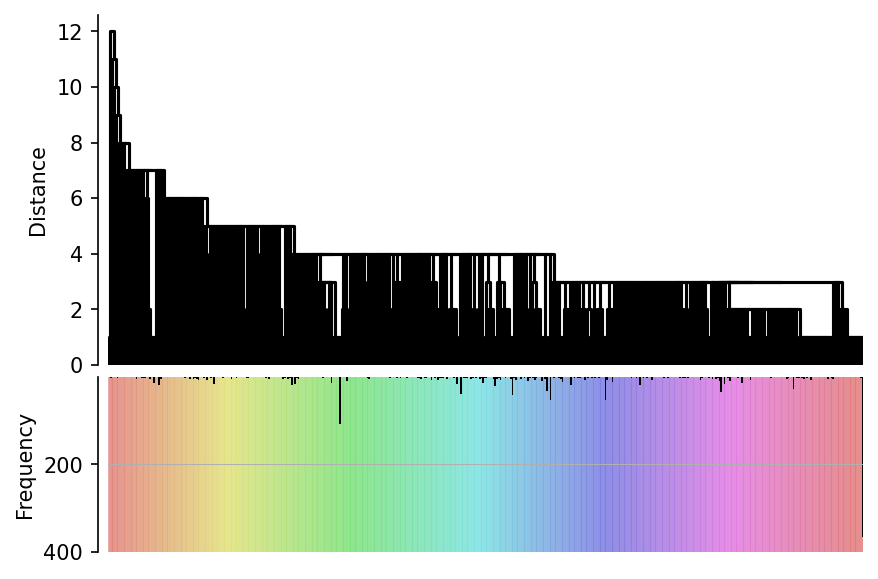

Finding allele frequencies from cluster indices
There are 6 clusters with [108, 41, 52, 53, 366, 1088]


In [8]:
snpdf, coho, leaves = phase3cluster(cohorts, transcript, contig, cut=1, t=0, min_cohort_size=40, metaquery="aim_species == 'gambiae'")

In [9]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [10]:
leaf_order = flatten_list(leaves)

### Load metadata and haplotypes

In [11]:
def check_order(meta, order, col='sample_id'):
    assert meta[col].to_list() == order, "Order of metadata is incorrect"
    print("correct order")

In [12]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

metahaps = metahaps.query("aim_species == 'gambiae'").reset_index(drop=True)
id_order = metahaps['sample_id'].to_list()
id_order_clustered = metahaps.iloc[leaf_order, :]['sample_id'].to_list()

In [13]:
check_order(metahaps, id_order)

correct order


In [16]:
#Subset the data to all aa changes above 5% frequency
snps = ag3.haplotypes(contig, sample_sets=cohorts, analysis='gamb_colu')
pos = allel.SortedIndex(snps['variant_position'])
gene_bool = pos.locate_ranges([29_021_062-5_000], [29_023_548+5_000])

meta = ag3.sample_metadata(cohorts)
meta = meta.query("aim_species == 'gambiae'")
sample_bool = np.isin(snps['sample_id'].compute(), meta['sample_id'])
snps = snps.isel(samples=sample_bool)

haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool).compute()).to_haplotypes()

aa_snps = snpdf.query("max_af > 0.05")['position'].to_list()
print(len(aa_snps))
pos_bool = pos.locate_intersection(aa_snps)[0]

haps2 = allel.GenotypeArray(snps['call_genotype'].isel(variants=pos_bool).compute()).to_haplotypes()

13


Load into pandas dataframe to use sns.heatmap(), reorder the samples so they are the same as the above dendrogram!

In [17]:
haps_df = pd.DataFrame(haps2)
haps_df['aa_change'] = snpdf.query("max_af > 0.05").reset_index()['aa_change']
haps_df = haps_df.set_index('aa_change')
haps_df = haps_df.iloc[::-1]
haps_df = haps_df.iloc[:, leaf_order] # can only run once!

Extract the order of the cohorts, and load karyotype data and merge with metadata, for plotting.

In [18]:
pop_column = 'country'

pop_order = metahaps.iloc[leaf_order, :][pop_column]
pop_order = pop_order.to_frame()
#pop_order['cohort_admin1_year'] = pop_order['cohort_admin1_year'].factorize()[0]

value_to_int = {j:i for i,j in enumerate(pd.unique(pop_order[pop_column].values.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Set1", n) 

karyo = pd.read_csv("/home/sanj/projects/gaardian/results/gaard_and_ag3.2la.karyo.tsv", sep="\t", index_col=0)
karyo = karyo.rename(columns={'partner_sample_id': 'sample_id'})

g = karyo.groupby('sample_id')
karyo['sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')

g = metahaps.groupby('sample_id')
metahaps['sample_id'] += g.cumcount().astype(str).replace("0", "").mask(g['sample_id'].transform('count')==1,'')
metahaps = metahaps.merge(karyo)

Load CNV-positive samples

In [19]:
cnv_ids = pd.read_csv("../../coe_cnv_sample_ids.tsv", sep="\t", index_col=0)

metahaps = metahaps.iloc[leaf_order, :]
metahaps['cnv_status'] = np.isin(metahaps['sample_id'], cnv_ids.iloc[:,0]).astype(int)
cnv = metahaps.loc[:,'cnv_status'].to_frame()

karyo = metahaps.loc[:, 'mean_genotype'].to_frame()
karyo['mean_genotype'] = karyo['mean_genotype'].round(0)

In [20]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

metahaps = metahaps.query("aim_species == 'gambiae'").reset_index(drop=True)
metahaps = metahaps.iloc[leaf_order, :]
check_order(metahaps, id_order_clustered)

correct order


In [21]:
pd.crosstab(karyo['mean_genotype'], cnv['cnv_status'])

cnv_status,0,1
mean_genotype,,
0.0,850,64
1.0,788,6


In [22]:
gene_bool = pos.locate_ranges([28_545_396], [28_547_938])
haps = allel.GenotypeArray(snps['call_genotype'].isel(variants=gene_bool).compute()).to_haplotypes()

In [23]:
mylen = np.vectorize(len)
bool_ = mylen(leaves) > 40

clusters = np.array(leaves)[bool_]
clusters = [np.array([c[0], c[-1]]) for c in clusters]
cluster_start_stop = [np.array([np.where(leaf_order == c[0])[0][0], np.where(leaf_order == c[1])[0][0]]) for c in clusters]

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2195: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [asarray(arg) for arg in args]
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [24]:
colours = probe.get_colour_dict(pop_order[pop_column])

In [25]:
bars = {}
for k,v in colours.items():
    bars[k] = plt.Rectangle((0,0),1,1,fc=v, edgecolor = 'none')

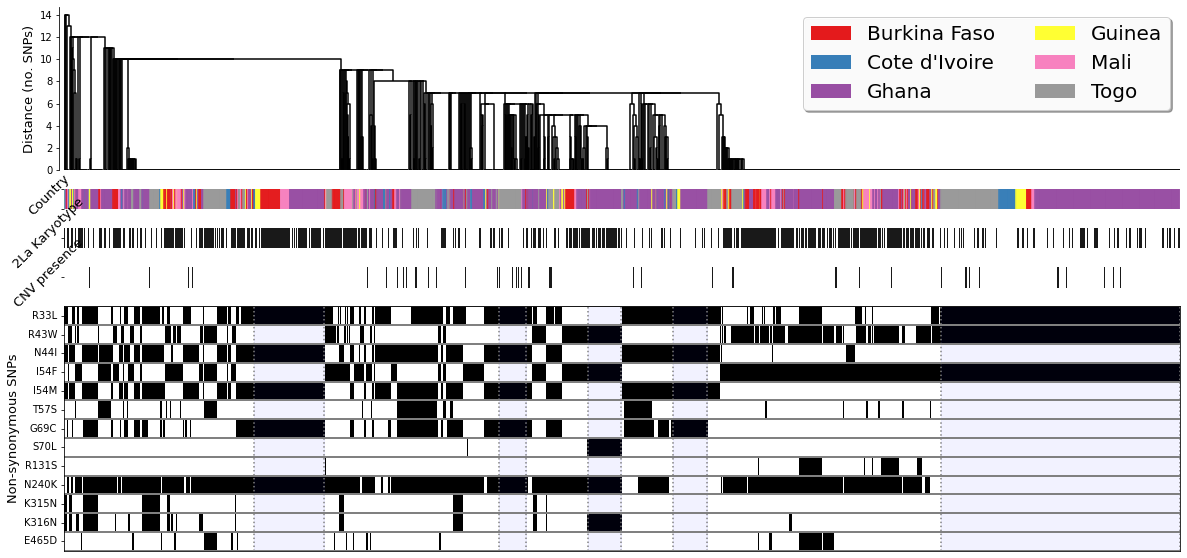

In [26]:
fig, ax = plt.subplots(5,1, figsize=[20,10], gridspec_kw={'height_ratios': [8, 1, 1, 1, 12]})

fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered_dendro(haps, 
                                                          truncate_distance=0,
                                                          cut_height=2,
                                                          dpi=150, label_clusters=False, ax_dend=ax[0])

ax[0].set_ylabel("Distance (no. SNPs)", fontsize=13)

for i, pop in enumerate(pop_order[pop_column]):
    ax[1].axvline(x=i, color=colours[pop])
sns.despine(ax=ax[1], left=True, bottom=True)

#sns.heatmap(ax=ax[1], data=pop_order.replace(value_to_int).T, cmap=cmap, xticklabels="", cbar=None)
for axes in ax[1:]:
    axes.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    
ax[1].set_xlim(0, len(pop_order))
    
sns.heatmap(ax=ax[2], data=karyo.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
sns.heatmap(ax=ax[3], data=cnv.T, cmap='Greys', xticklabels="", cbar=None, alpha=0.9)
sns.heatmap(ax=ax[4], data=haps_df, cmap='Greys', cbar=None, xticklabels="")

ax[1].set_ylabel('Country', rotation = 45, fontsize=13)
ax[1].set_yticklabels("")
ax[2].set_ylabel('2La Karyotype', rotation = 45, fontsize=13)
ax[2].set_yticklabels("")
ax[3].set_ylabel('CNV presence', rotation = 45, fontsize=13)
ax[3].set_yticklabels("")
ax[4].set_ylabel('Non-synonymous SNPs', fontsize=13)


for start, stop in cluster_start_stop:
    ax[4].axvline(start, color='grey', linestyle="dotted")
    ax[4].axvline(stop, color='grey', linestyle="dotted")
    
    dend_patch_xy = (start, 0)
    ax[4].add_patch(plt.Rectangle(xy=dend_patch_xy,
                                       width=stop-start,
                                            height=40,
                                          color="blue", alpha=0.05))

for i in range(haps_df.shape[0] + 1):
    ax[4].axhline(i, color='grey', lw=2)
    
for _, spine in ax[4].spines.items():
    spine.set_visible(True)
    
l = ax[0].legend(bars.values(), bars.keys(), loc='best', ncol=2, fancybox=True, shadow=True, framealpha=0.95, prop={'size':20})
l.draw_frame(True)

### EHH in sweep clusters 

Designate flanks

In [27]:
loc_focus = 29_022_000
flanking = 50_000

upstream = pos.locate_ranges([loc_focus-flanking], [loc_focus])
downstream = pos.locate_ranges([loc_focus], [loc_focus+flanking])
pos_ehh_region = np.concatenate([pos[upstream], pos[downstream]])

### Calculate EHH in sweep cluster and WT

In [28]:
# get wt key 
keys = pd.Series(coho.keys())
wt_key = keys[keys.str.contains("wt")].to_list()[0]
wt_idxs = coho[wt_key]

# subset to down and upstream and calculate ehh decay in WT 
snps_up_wt = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(wt_idxs, axis=1)
snps_down_wt = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(wt_idxs, axis=1)
ehh_up_wt = allel.ehh_decay(snps_up_wt)
ehh_down_wt = allel.ehh_decay(snps_down_wt)
ehh_wt = np.concatenate([ehh_up_wt[::-1], ehh_down_wt])
ehh_wt_df = pd.DataFrame({'ehh': ehh_wt, 'group':wt_key, 'pos':pos_ehh_region})

# and then same in sweeps 
ehh_dict = {}
for sweep, idxs in coho.items():
    
    if 'wt' in sweep:
        continue
                    
    snps_up_sweep = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    snps_down_sweep = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(idxs, axis=1)
    
    ehh_up_sweep = allel.ehh_decay(snps_up_sweep)
    ehh_down_sweep = allel.ehh_decay(snps_down_sweep)

    ehh_sweep = np.concatenate([ehh_up_sweep[::-1], ehh_down_sweep])
    ehh_dict[sweep] = pd.DataFrame({'ehh': ehh_sweep, 'group':sweep, 'pos':pos_ehh_region})


In [29]:
ehh_df = pd.concat([pd.concat(ehh_dict).reset_index(drop=True), ehh_wt_df], axis=0).reset_index(drop=True)

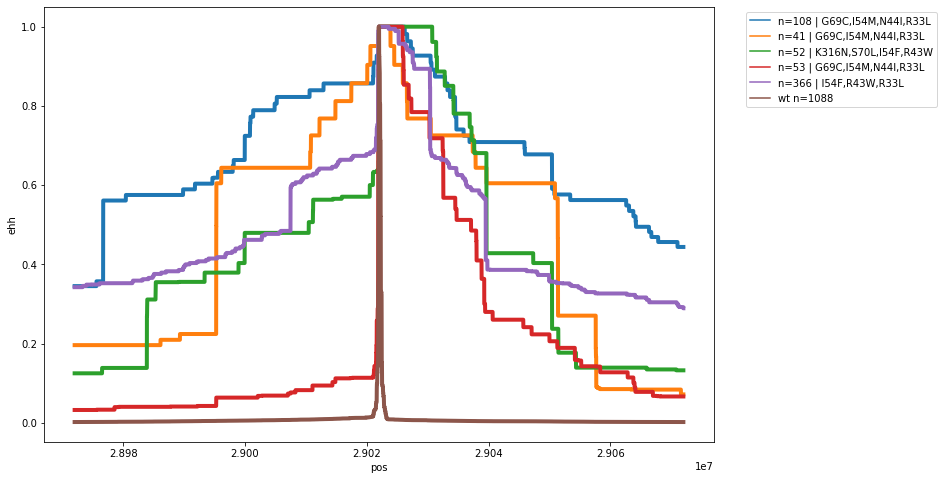

In [30]:
plt.figure(figsize=[12,8])
sns.lineplot(data=ehh_df, x='pos', y='ehh', hue='group', linewidth=4)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## With / without CNV in the CNV containing sweep

In [31]:
cnv_sweep_inds = coho['n=76 | N512K,D496E,V441G,L304V,E276D,E249D,A228V,K163N,E28V']
wt_inds = coho['wt n=556']

meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns
metahaps = metahaps.query("aim_species == 'gambiae'").reset_index(drop=True)

meta_cnv_sweep = metahaps.take(cnv_sweep_inds)

KeyError: 'n=76 | N512K,D496E,V441G,L304V,E276D,E249D,A228V,K163N,E28V'

In [32]:
meta_cnv_bool = np.isin(meta_cnv_sweep['sample_id'], cnv_ids.iloc[:,0])

meta_cnv = meta_cnv_sweep[meta_cnv_bool]
meta_non_cnv = meta_cnv_sweep[~meta_cnv_bool]

NameError: name 'meta_cnv_sweep' is not defined

In [126]:
snps_up_cnv = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(meta_cnv_bool, axis=1)
snps_down_cnv = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(meta_cnv_bool, axis=1)
ehh_up_cnv = allel.ehh_decay(snps_up_cnv)
ehh_down_cnv = allel.ehh_decay(snps_down_cnv)
ehh_cnv = np.concatenate([ehh_up_cnv[::-1], ehh_down_cnv])
ehh_cnv = pd.DataFrame({'ehh': ehh_cnv, 'group':'sweep_cnv', 'pos':pos_ehh_region})

snps_up_non_cnv = allel.GenotypeArray(snps.isel(variants=upstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(~meta_cnv_bool, axis=1)
snps_down_non_cnv = allel.GenotypeArray(snps.isel(variants=downstream)['call_genotype']).to_haplotypes().take(cnv_sweep_inds, axis=1).compress(~meta_cnv_bool, axis=1)
ehh_up_non_cnv = allel.ehh_decay(snps_up_non_cnv)
ehh_down_non_cnv = allel.ehh_decay(snps_down_non_cnv)
ehh_non_cnv = np.concatenate([ehh_up_non_cnv[::-1], ehh_down_non_cnv])
ehh_non_cnv = pd.DataFrame({'ehh': ehh_non_cnv, 'group':'sweep_non_cnv', 'pos':pos_ehh_region})


In [127]:
ehh_cnv_df = pd.concat([ehh_cnv, ehh_non_cnv, ehh_wt_df]).reset_index(drop=True)

<AxesSubplot:xlabel='pos', ylabel='ehh'>

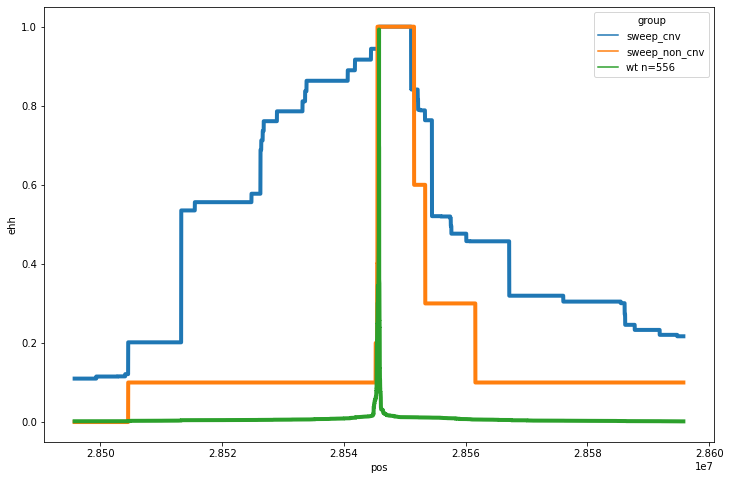

In [128]:
plt.figure(figsize=[12,8])
sns.lineplot(data=ehh_cnv_df, x='pos', y='ehh', hue='group', linewidth=4)

In [370]:
cnvs_ids = pd.read_csv("../../coe_cnv_sample_ids.tsv", sep="\t", index_col=0)

In [25]:
import warnings
warnings.filterwarnings('ignore')

karyotypes = pd.read_csv("/home/sanj/projects/gaard/results/gaard_karyotypes.tsv", sep="\t")
karyo_2la2 = pd.read_csv("/home/sanj/ag1000g/ag3_karyotypes.tsv", sep="\t", index_col=0).rename(columns={'partner_sample_id':'sample_id'})

karyo_2la = karyotypes.query("inversion == '2La'")

karyo_2la.loc[:, 'mean_genotype'] = karyo_2la.loc[:,'mean_genotype'].round(0)
karyo_2la2.loc[:, 'mean_genotype'] = karyo_2la2.loc[:,'mean_genotype'].round(0)

In [26]:
ag3_meta = meta[np.isin(meta['sample_id'], karyo_2la2['sample_id'])]
ag3_meta = ag3_meta.merge(karyo_2la2, on='sample_id')

gaard_meta = meta[np.isin(meta['partner_sample_id'], karyo_2la['partner_sample_id'])]
gaard_meta = gaard_meta.merge(karyo_2la, how='left', on='partner_sample_id')

meta2 = pd.concat([ag3_meta, gaard_meta], axis=0).query("aim_species == 'gambiae'")
metahaps = pd.DataFrame(np.repeat(meta2.values, 2, axis=0))
metahaps.columns = meta2.columns

In [48]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

metahaps = metahaps.query("aim_species == 'gambiae'")

for k,v in coho.items():
    
    meta = metahaps.take(v)
    ids = meta['sample_id']
    a = meta['aim_species'].value_counts()
    meta['cnv_status'] = np.isin(meta['sample_id'], cnv_ids).astype(int)
    b = meta.location.value_counts()
    print("------------------------------------")
    print(k)
    print(a)
    print("\n")
    print(meta['cnv_status'].value_counts())
    print("\n")
    print(b)
    print("------------------------------------")
    print("\n")

------------------------------------
n=275 | E477V,E249D,A228V
gambiae    275
Name: aim_species, dtype: int64


0    273
1      2
Name: cnv_status, dtype: int64


Madina_North      126
Pala               34
Obuasi             31
Kababougou         26
Bana Village       13
Aboisso            10
Souroukoudinga      9
Koraboh             7
Koundara            6
Baguida             6
Ouassorola          3
Kela                2
Koforidua           1
Madina_West         1
Name: location, dtype: int64
------------------------------------


------------------------------------
n=62 | N512K,V441G,L304V,E276D,E249D,A228V,H199Q
gambiae    62
Name: aim_species, dtype: int64


0    57
1     5
Name: cnv_status, dtype: int64


Baguida         21
Obuasi          17
Madina_West      8
Aboisso          4
Koforidua        3
Madina_North     3
Koraboh          3
Koundara         2
Kababougou       1
Name: location, dtype: int64
------------------------------------


------------------------------------
n=

In [122]:
meta = metahaps.iloc[coho['n=73 | N512K,D496E,V441G,L304V,E276D,E249D,A228V,K163N,E28V']]
meta.location.value_counts()

Baguida    37
Obuasi     35
Aboisso     1
Name: location, dtype: int64

In [ ]:
snpdf, coho = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=2, t=0, min_cohort_size=40)

AG1000G-CD, query=None, cohort_size : 152
Finding start, stop...
Clustering genotypes


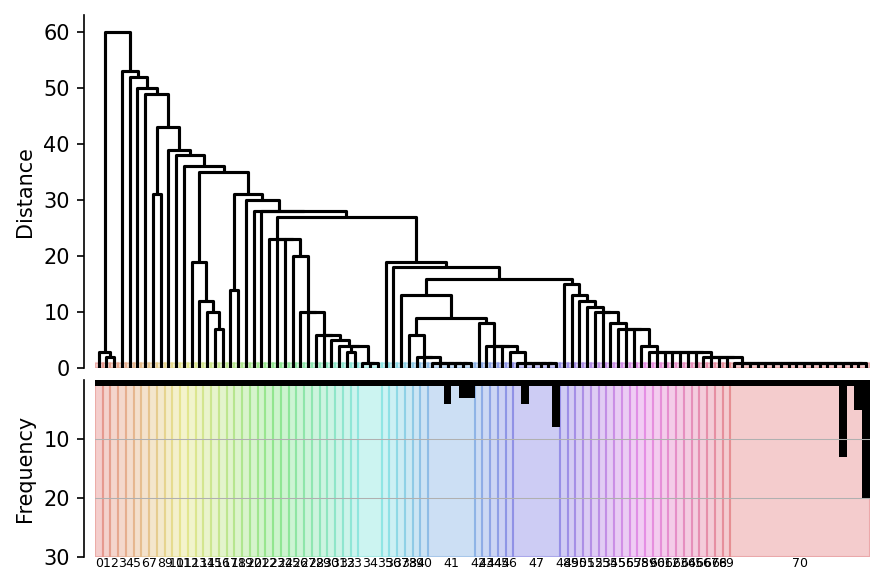

Finding allele frequencies from cluster indices
There are 4 clusters with [13, 16, 53, 70]


In [93]:
snpdf, coho = phase3cluster("AG1000G-CD", "AGAP004707-RD", contig, cut=1, t=0, min_cohort_size=10)

AG1000G-GH, query=None, cohort_size : 200
Finding start, stop...
Clustering genotypes


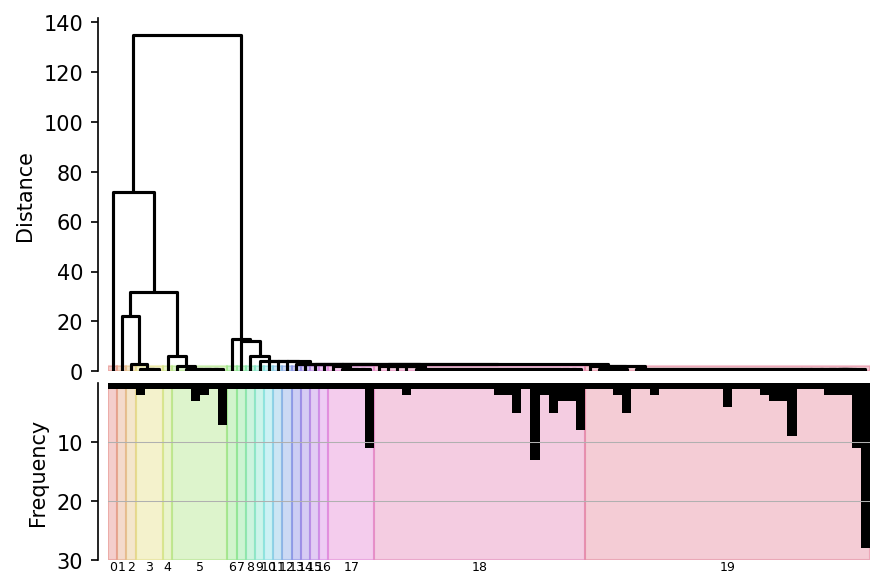

Finding allele frequencies from cluster indices
There are 4 clusters with [15, 58, 93, 19]
Sweep n=15 15 5
Sweep n=58 58 5
Sweep n=93 92 5
wt n=19 19 5


In [25]:
snpdf, coho = phase3cluster(cohorts[3], "AGAP004707-RD", contig, cut=0, t=0, min_cohort_size=5)

### Get freqs of multiallelic SNPs too.

In [78]:
df_effects = ag3.snp_effects(
        transcript=transcript, 
    ) 

In [128]:
aa_freqs = ag3.aa_allele_frequencies("AGAP001356-RA", coh_homs, min_cohort_size=0)

In [130]:
#aa_freqs.reset_index()

In [79]:
aa_freqs = df_effects.merge(aa_freqs.reset_index())

AG1000G-UG, query=None, cohort_size : 414
Finding start, stop...
Clustering genotypes


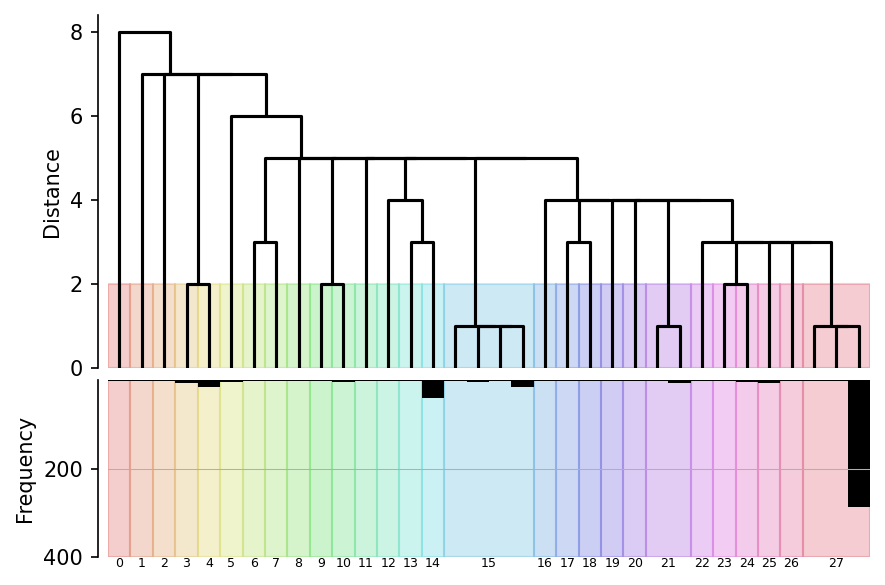

Finding allele frequencies from cluster indices
There are 6 clusters with [15, 40, 22, 7, 288, 32]
Sweep n=15 15 5
Sweep n=40 40 5
Sweep n=22 22 5
Sweep n=7 6 5
Sweep n=288 288 5
wt n=32 32 5


In [538]:
snpdf, ugcohort = phase3cluster("AG1000G-UG", "AGAP002867-RA", "2R", cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 200
Finding start, stop...
Clustering genotypes


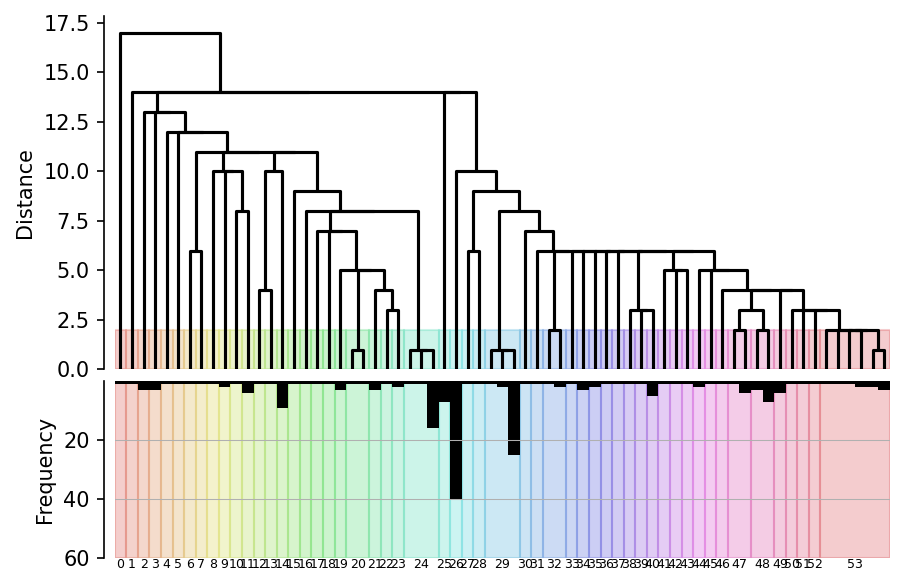

Finding allele frequencies from cluster indices
{'Sweep n=9': array([ 21,  30,  56,  59,  98, 122, 150, 168, 193]), 'Sweep n=18': array([  4,   5,  10,  26,  27,  32,  50,  54,  75,  77, 113, 120, 121,
       145, 160, 167, 171, 194]), 'Sweep n=7': array([ 14,  23,  39,  84, 104, 156, 182]), 'Sweep n=40': array([ 12,  13,  15,  16,  17,  37,  38,  40,  42,  44,  46,  47,  60,
        61,  63,  65,  82,  83,  85,  86,  87,  90,  91, 105, 106, 107,
       108, 129, 130, 131, 134, 135, 155, 157, 161, 174, 175, 177, 178,
       179]), 'Sweep n=28': array([  7,   8,  28,  36,  74,  93,  97, 114, 115, 116, 127, 138, 139,
       141, 147, 151, 158, 162, 165, 169, 173, 176, 180, 181, 185, 187,
       196, 198]), 'Sweep n=10': array([  2,   3,  20,  57, 101, 112, 118, 133, 164, 166])}
There are 7 clusters with [9, 18, 7, 40, 28, 10, 68]
Sweep n=9 9 5
Sweep n=18 18 5
Sweep n=7 7 5
Sweep n=40 40 5
Sweep n=28 28 5
Sweep n=10 10 5
wt n=68 67 5


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/dask/array/routines.py:1951: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return a[(slice(None),) * axis + (indices,)]


In [244]:
snpdd, coh = phase3cluster(cohorts[3], transcript, contig, cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 72
Finding start, stop...
Clustering genotypes


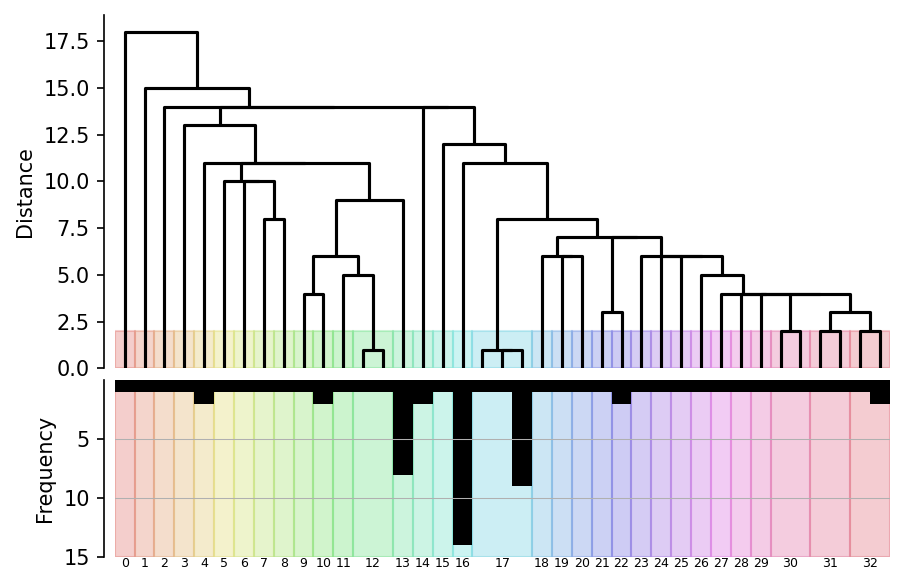

Finding allele frequencies from cluster indices
{'Sweep n=8': array([ 2,  3,  6, 12, 36, 37, 55, 66]), 'Sweep n=14': array([ 9, 15, 20, 21, 24, 25, 31, 32, 33, 40, 41, 51, 60, 61]), 'Sweep n=11': array([ 1,  4,  8, 27, 34, 47, 52, 57, 59, 68, 70])}
There are 4 clusters with [8, 14, 11, 39]
Sweep n=8 8 5
Sweep n=14 14 5
Sweep n=11 11 5
wt n=39 38 5


In [245]:
df = phase3cluster(cohorts[3], transcript, contig, metaquery="aim_species == 'gambiae'",cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 128
Finding start, stop...
Clustering genotypes


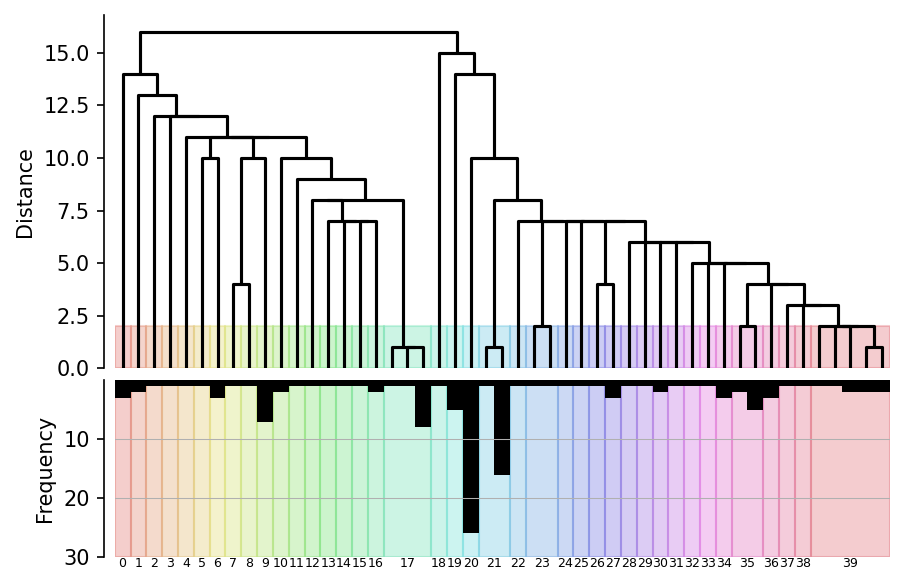

Finding allele frequencies from cluster indices
{'Sweep n=7': array([ 23,  25,  51,  67,  85, 109, 126]), 'Sweep n=10': array([  4,   5,   8,  40,  57,  59,  79,  99, 106, 113]), 'Sweep n=26': array([ 10,  11,  13,  14,  15,  28,  30,  32,  34,  36,  37,  46,  47,
        49,  62,  63,  65,  74,  91,  92,  93, 105, 107, 115, 116, 117]), 'Sweep n=17': array([  6,  56,  69,  80,  81,  89,  94,  95,  97, 101, 108, 111, 114,
       118, 119, 121, 123]), 'Sweep n=8': array([  2,   3,  18,  43,  71,  78,  82, 110])}
There are 6 clusters with [7, 10, 26, 17, 8, 48]
Sweep n=7 7 5
Sweep n=10 10 5
Sweep n=26 26 5
Sweep n=17 17 5
Sweep n=8 8 5
wt n=48 47 5


In [246]:
df = phase3cluster(cohorts[3], transcript, contig, metaquery="aim_species == 'coluzzii'",cut=2, t=0, min_cohort_size=5)

### Distance between sweeps

In [357]:
sample_set = cohorts[3]
metaquery = None
cut=2
t=0
min_cohort_size=4

genepos = ag3.snp_sites(region=gene, field='POS').compute()
genehaps = haps.compress(pos.locate_intersection(genepos)[0], axis=0)

dists = []
xs,ys = [], []

for x, y in itertools.combinations(coh.keys(),2):
    
    haps2 = allel.HaplotypeArray(genehaps.take([coh[x][0], coh[y][0]], axis=1))
    dist = scipy.spatial.distance.pdist(haps2.T, metric='hamming')
    dists.append(dist * haps2.shape[0])
    xs.append(x)
    ys.append(y)
    

df = pd.DataFrame({0:xs, 1:ys, 'dist':dists})
df.head(4)